In [1]:
import matplotlib.pyplot as plt
from neuron import h
import numpy as np
print(h.nrnversion())

NEURON -- VERSION 9.0.1 HEAD (b12a541+) 2025-11-14


## Why the letter h?

Originally, NEURON used a language called HOC, created before Python existed.

In HOC scripts, we use commands directly like create soma, insert hh

In Python, h is the handle to the entire HOC namespace.

#### It gives you access to EVERYTHING inside the NEURON simulator.

In [2]:
# Create a soma section
soma=h.Section(name='soma')
soma.L=20
soma.diam=20
soma.insert('hh')

soma

### soma
Soma = cell body,  exists in center of the biological neuron 
The soma in HOC is a section

Meaning:
It is a piece of cable that represents the electrical behavior of the biological soma.



| Biology            | NEURON HOC                                       |
| ------------------ | ------------------------------------------------ |
| Soma (cell body)   | A section named `soma`                           |
| Ion channels       | `insert hh`, `insert pas`, etc.                  |
| Membrane area      | `L` and `diam`                                   |
| AP initiation zone | Where hh is inserted (usually soma/axon hillock) |
| Synaptic inputs    | Objects attached to soma or dendrites            |



In [3]:
# inject current into soma
stim=h.IClamp(soma(0.5))
stim.delay=50  #ms
stim.dur=500  #ms
stim.amp=0.1  #na

| Code                  | Meaning                            |
| --------------------- | ---------------------------------- |
| `h.IClamp(soma(0.5))` | Put an electrode at center of soma |
| `stim.delay = 50`     | Start injecting at 50 ms           |
| `stim.dur = 200`      | Keep injecting for 200 ms          |
| `stim.amp = 0.1`      | Inject 0.1 nanoampere current      |


#### In simulations, we use IClamp to mimic these conditions.

In [4]:
# record voltage and time 
v = h.Vector()     # create vector
v.record(soma(0.5)._ref_v)   # record voltage

t = h.Vector()
t.record(h._ref_t)           # record time


Vector[1]

A Vector in NEURON is like a list that collects data:

v = list of voltages over time

t = list of time points
  record() tells NEURON what value to store at each time step.

It needs the memory address of the variable you want to record.

In NEURON, we get that using _ref_ variables.



h._ref_t means:“Give me a pointer to the simulation time variable.”

Time (ms):     0    0.025   0.05   0.075   0.1   ...  
Voltage (mV): -65   -65     -64    -20     +30   ...


| Code                         | Meaning                            |
| ---------------------------- | ---------------------------------- |
| `v = h.Vector()`             | Create an empty voltage list       |
| `t = h.Vector()`             | Create an empty time list          |
| `v.record(soma(0.5)._ref_v)` | Record voltage from center of soma |
| `t.record(h._ref_t)`         | Record time during simulation      |



In [5]:
h.load_file("stdrun.hoc")

1.0

In [6]:
# Run simulation
h.tstop = 600
#dt=0.025
h.run()

0.0

#### sometimes in python 3.10.11 Before using h.tstop or h.run(), load the standard run system: ####


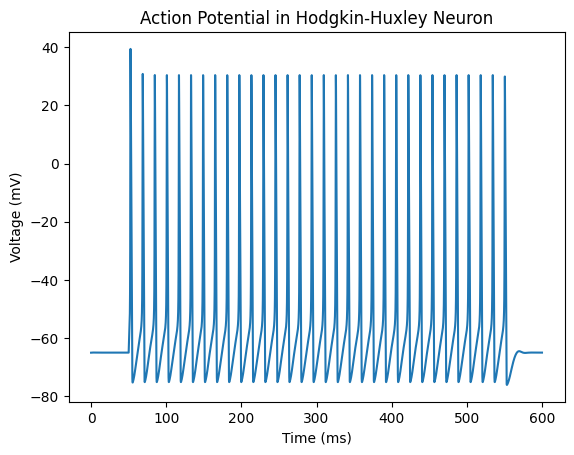

In [7]:
# Plot
plt.plot(t, v)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Action Potential in Hodgkin-Huxley Neuron')
plt.show()

NOTE: _ref_v means “REFERENCE to voltage” 

| Variable    | Meaning     |
| ----------- | ----------- |
| `._ref_v`   | voltage     |
| `._ref_i`   | current     |
| `._ref_g`   | conductance |
| `h._ref_t`  | time        |
| `h._ref_dt` | time step   |


## How recording works inside these steps

Recording works like this:

NEURON steps time forward:
t = 0.025 → 0.05 → 0.075 → ...

At each time step:

NEURON measures voltage at soma(0.5)

NEURON stores that number in the Vector v

NEURON stores the time in Vector t

So after simulation:

t = [0, 0.025, 0.05, 0.075, ...]

v = [-65, -65, -64.9, -60, ..., +30, ...]

These two lists allow us to plot voltage vs time

#

In [8]:

soma.insert("hh")
# recording sodium current
ina=h.Vector().record(soma(0.5)._ref_ina)

#recording potassium current 
ik=h.Vector().record(soma(0.5)._ref_ik)

t  = h.Vector().record(h._ref_t)

h.tstop=300
h.run()

0.0

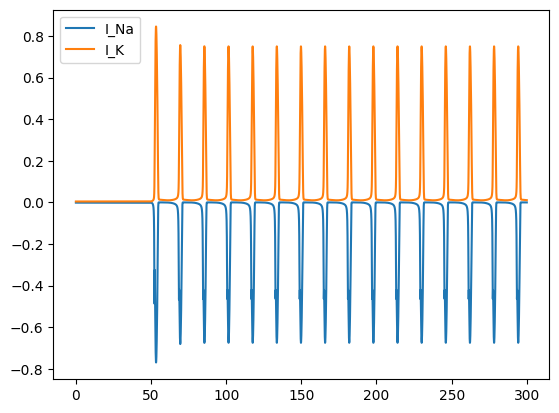

In [9]:
plt.plot(list(t),list(ina),label="I_Na")
plt.plot(list(t),list(ik),label="I_K")
plt.legend()
plt.show()

## Interpretation 

Because negative current means positive ions (Na⁺) are flowing into the cell.

✔ Inward flow of Na⁺ = negative current
✔ Outward flow of ions = positive current

This is the convention used in biology and adopted by NEURON.

When Na⁺ rushes IN, current goes negative

When K⁺ rushes OUT, current goes positive

This is why:

Blue curve (I_Na) has a negative peak

Orange curve (I_K) has a positive peak

### It comes from the patch-clamp electrophysiology tradition:

Current INTO the cell is assigned a NEGATIVE sign
Current OUT of the cell is assigned a POSITIVE sign

This feels reversed at first, but here’s why:

The amplifier in patch-clamp defines inward current as negative.

Hodgkin–Huxley used the same convention.

NEURON follows this standard.

So your negative I_Na peak is exactly what every neuroscience textbook and experiment shows.

# Multi Compartment Neuron

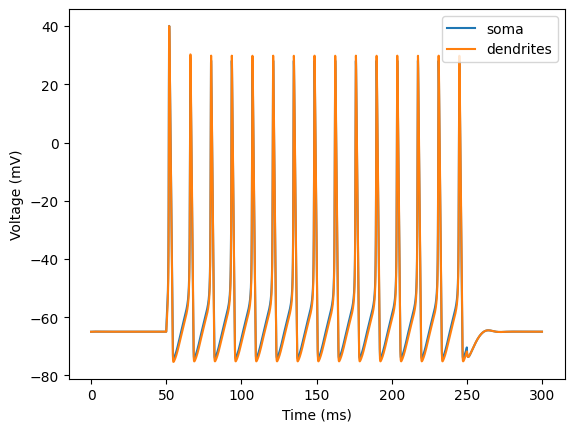

In [ ]:
from neuron import h
import matplotlib.pyplot as plt

soma=h.Section(name='soma')
soma.L=20
soma.diam=20
soma.insert('hh')

dend = h.Section(name='dend')
dend.L=200  #long dend
dend.diam=2
dend.insert('hh')

dend.connect(soma(1))  #connection of dend to soma

stim=h.IClamp(soma(0.5))   #stimulation to soma
stim.delay=50
stim.dur=200
stim.amp=0.3

t=h.Vector().record(h._ref_t)
vsoma=h.Vector().record(soma(0.5)._ref_v)
vdend=h.Vector().record(dend(0.5)._ref_v)   #end of dend

h.tstop=300
h.run()

plt.plot(list(t),list(vsoma),label='soma')
plt.plot(list(t),list(vdend),label='dendrites')
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.show()

Now we will add the Synapses (APMA)

In [11]:
syn=h.ExpSyn(dend(0.8))    #APMA-Like 
syn.tau=2                   #decay time constant

Trigger it with an event (NetCon)

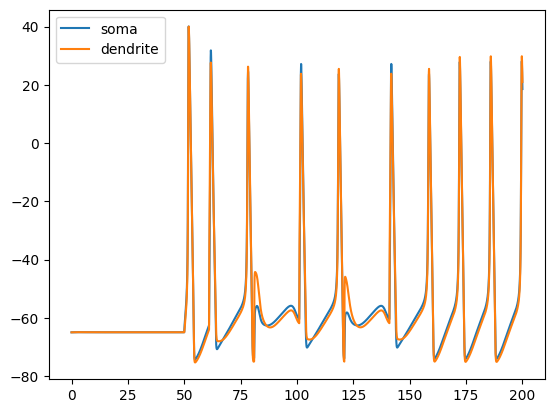

In [12]:
stim_nc=h.NetStim()
stim_nc.number=5     #mumber of spikes 
stim_nc.start=60     #first spike time
stim_nc.interval=20  #ms between spikes

nc=h.NetCon(stim_nc, syn)
nc.weight[0]=0.1


h.tstop=200
h.run()


plt.plot(t,vsoma, label="soma")
plt.plot(t, vdend, label='dendrite')
plt.legend()
plt.show()

### Interpretetion

Dendritic spikes can exceed somatic spikes.


| Line of code        | Meaning                               |
| ------------------- | ------------------------------------- |
| `ExpSyn(dend(0.8))` | Place AMPA synapse on dendrite        |
| `tau=2`             | Fast decay like AMPA                  |
| `NetStim()`         | Fake presynaptic neuron               |
| `number=5`          | 5 spikes total                        |
| `start=60`          | First spike at 60 ms                  |
| `interval=20`       | Spikes spaced 20 ms apart             |
| `NetCon(stim, syn)` | Connect presynaptic spikes to synapse |
| `weight = 0.1`      | Strength of synaptic effect           |



AMPA = fast excitatory synapse that lets Na⁺ in and creates EPSPs.


#### Visualizing the Hodgkin–Huxley gating variables (m, h, n)

Sodium channels have:
m = activation gate
h = inactivation gate

##### I_Na ∝ m³ * h  


Potassium channels have:
n = activation gate

##### I_K ∝ n⁴


m jumps up → INa rushes in → spike rises

h goes down → sodium stops

n goes up → potassium exits → spike falls

In [16]:
t = h.Vector().record(h._ref_t)
m=h.Vector().record(soma(0.5).hh._ref_m)
h_gate=h.Vector().record(soma(0.5).hh._ref_h)
n = h.Vector().record(soma(0.5).hh._ref_n)


h.tstop = 40
h.run()

#for converting from hocvector to np array
t = np.array(t.to_python())
m = np.array(m.to_python())
h_gate = np.array(h_gate.to_python())
n = np.array(n.to_python())

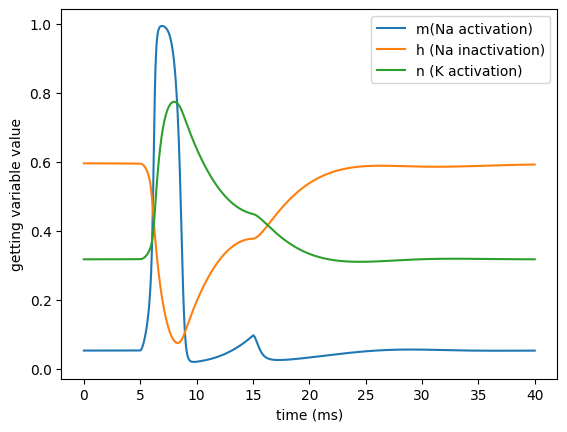

In [17]:
plt.figure()

plt.plot(t,m,label="m(Na activation)")
plt.plot(t,h_gate,label="h (Na inactivation)")
plt.plot(t,n,label="n (K activation)")

plt.xlabel("time (ms)")
plt.ylabel("getting variable value")
plt.legend()
plt.show()

| Variable       | Ion channel          | Meaning                     |
| -------------- | -------------------- | --------------------------- |
| **m (blue)**   | Sodium activation    | How much Na⁺ channels OPEN  |
| **h (orange)** | Sodium inactivation  | How much Na⁺ channels CLOSE |
| **n (green)**  | Potassium activation | How much K⁺ channels OPEN   |


They each go between 0 and 1, representing a probability of a gate being open.



m↑ fast → Na channels open → spike RISES
h↓ fast → Na channels close → spike PEAKS
n↑ slow → K channels open → spike FALLS


### Visualize I_Na and I_K alongside m/h/n and voltage

In [ ]:

t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)

m=h.Vector().record(soma(0.5).hh._ref_m)
h_gate=h.Vector().record(soma(0.5).hh._ref_h)
n = h.Vector().record(soma(0.5).hh._ref_n)

ina = h.Vector().record(soma(0.5)._ref_ina)
ik  = h.Vector().record(soma(0.5)._ref_ik)

h.tstop = 40
h.run()

#for converting from hocvector to np array
t = np.array(t.to_python())
v = np.array(v.to_python())

m = np.array(m.to_python())
h_gate = np.array(h_gate.to_python())
n = np.array(n.to_python())
ina = np.array(ina.to_python())
ik = np.array(ik.to_python())

<function matplotlib.pyplot.show(close=None, block=None)>

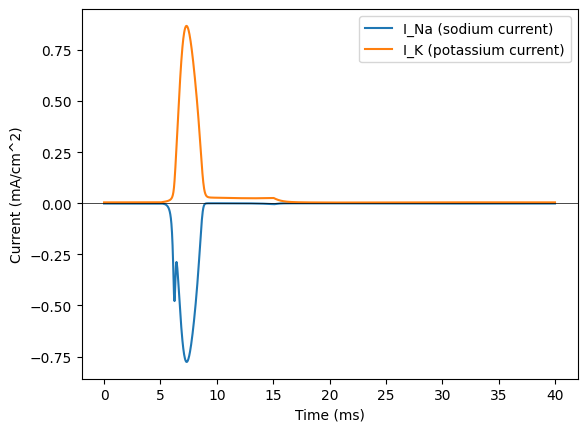

In [23]:
plt.figure()
plt.plot(t,ina,label="I_Na (sodium current)")
plt.plot(t,ik,label="I_K (potassium current)")
plt.axhline(0,color='black',linewidth=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Current (mA/cm^2)")
plt.legend()
plt.show


#### Interpretation

Sodium:
Na⁺ flows into the cell

In neuron convention, inward = negative current

So a downward dip represents Na⁺ influx → spike rising.



Potassium:
K⁺ flows out of the cell

Outward = positive current

So an upward wave represents K⁺ efflux → spike falling.